# SciML SANUM2024
# Lab 4: Solving differential equations in DifferentialEquations.jl

We now consider the solution of time-evolution ordinary differential equations (ODEs) using the
DifferentialEquations.jl framework. An important feature is the ability to
use automatic-differentiation with the numerical solutions, allowing us to solve
simple nonlinear equations or optimisation problems involving parameters or initial conditions in the ODEs.

**Learning Outcomes**
1. Solving ODEs using DifferentialEquations.jl
2. Differentiating an ODE with respect to parameters or initial conditions.
3. Solving simple nonlinear equations or optimisation problems involving paramters in an ODE.

In [1]:
using DifferentialEquations, Plots, LinearAlgebra, Test

## 4.1 Solving ODEs with DifferentialEquations.jl

DifferentialEquations.jl is a powerful framework for solving many different types of equations with
many different types of solves, including stochastic differential equations, retarded differential equations,
mixed discrete-continuous equations, PDEs,  and more. Here we will focus on the simplest case of second-order
time-evolution ODEs, beginning with the classic pendulum equation.

Consider again the pendulum equation with friction
$$
u'' = τ u' - \sin u
$$
which we rewrite as a first order system:
$$
\begin{bmatrix}
   u' \\
   v'
   \end{bmatrix} = \begin{bmatrix} v \\ -τv - \sin u \end{bmatrix}
$$
We can represent the right-hand side of this equation as a function that writes to a
`du` vector (thus avoiding allocations) as follows:

In [2]:
function pendulum_rhs!(du, 𝐮, τ, t)
    u,v = 𝐮
    du[1] = v
    du[2] = -sin(u) - τ*v
end

pendulum_rhs! (generic function with 1 method)

Here `τ` plays the role of a parameter: for fast time-stepping its essential that we know the types
at compile time and hence its much better to pass in a parameter than refer to a global variable.
We can now construct a representation of the ODE problem as follows:

In [3]:
τ = 0.0 # no friction
T = 10.0 # final time
u₀, v₀ = 1,1 # initial conditions for poistion and velocity
prob = ODEProblem(pendulum_rhs!, [u₀, v₀], (0.0, T), τ)

ODEProblem with uType Vector{Int64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Int64}:
 1
 1

We can find the solution to the problem as follows:

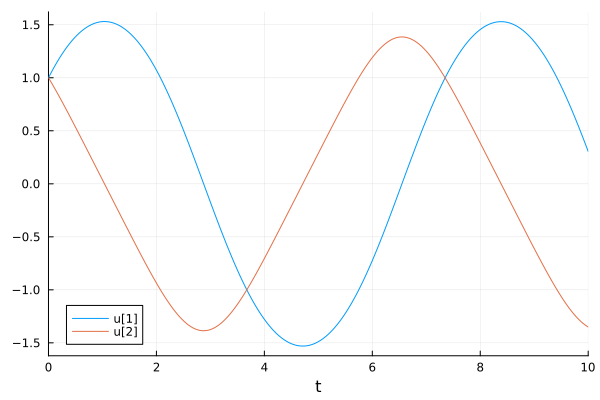

In [4]:
sol = solve(prob)
plot(sol)

DifferentialEquations.jl has many diferent time-steppers, eg, `Tsit5()` is
an explicit Runge–Kutta method (a more efficient analogue of ode45 in Matlab).
Because we have access to automatic differentiation, we can also easily use implicit methods
(even though they aren't needed here). Here's the same problem using an implicit method\
with tolerances specified:

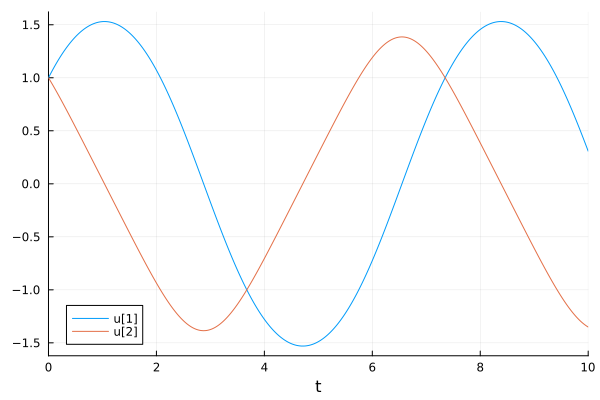

In [5]:
sol = solve(prob, Rodas4(), abstol = 1e-10, reltol = 1e-10)
plot(sol)

------

**Problem 1** Approximate  a solution to the predator-prey model
$$
\begin{bmatrix} x' \\ y' \end{bmatrix} =  \begin{bmatrix}αx - βxy \\  δxy - γy\end{bmatrix}
$$
on $T ∈ [0,10]$ with $α , β,δ,γ = 1,2,3,4$ with initial condition $[1,2]$.

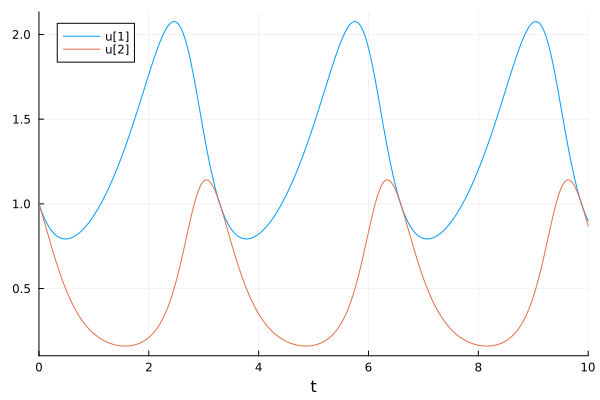

In [6]:
function predatorprey_rhs!(du, 𝐮, ps, t)
    (α,β,δ,γ) = ps
    # TODO: Implement the right-hand side for the predator prey model
    # SOLUTION
    x,y = 𝐮
    du[1] = α*x - β*x*y
    du[2] = δ*x*y - γ*y
    # END
end

# TODO: use predatorprey_rhs! to setup an ODE and plot the solution
# SOLUTION
prob = ODEProblem(predatorprey_rhs!, [u₀, v₀], (0.0, T), (1,2,3,4))
sol = solve(prob, Tsit5(), abstol = 1e-10, reltol = 1e-10)
plot(sol)
# END

------

## 4.2 Combining auto-differentiation with DifferentialEquations.jl

The combination of automatic-differentiation and time-stepping allows for differentiating
with respect to parameters through an actual solve. For forward-mode automatic differentiation
this is intuitive: the values at each time-step are now dual numbers. Here we see a simple
example using ForwardDiff.jl. Consider the problem of choosing a friction so at the end time
the pendulum is at the bottom (but not necessarily stationary). We can set this up as follows,
where for simplicity we hard-code the initial conditions as $[1,1]$:

In [7]:
function pendulum_friction(τ)
    T = 10.0 # final time
    u₀, v₀ = 1,1 # initial conditions
    prob = ODEProblem(pendulum_rhs!, [u₀, v₀], (0.0, T), τ)
    solve(prob, Vern9(), abstol = 1e-10, reltol = 1e-10) # Vern9 is an explicit Runge-Kutta method
end

pendulum_friction_stop(τ) = pendulum_friction(τ)[end][1] # find the value of u at the final time

pendulum_friction_stop(0.1) # value at T = 10 with friction equal to 0.1

-0.2508799635065052

We can immediately differentiate with respect to `τ`:

In [8]:
using ForwardDiff
ForwardDiff.derivative(pendulum_friction_stop, 0.1)

-1.3753289141679312

Behind the scenes this is running the time-stepper with dual numbers. We can use this in a simple newton iteration to, for example, find the friction
that results in a desired end conditon:

In [9]:
τ = 0.1
for k = 1:10
    τ = τ - ForwardDiff.derivative(pendulum_friction_stop, τ) \ pendulum_friction_stop(τ)
end
τ, pendulum_friction_stop(τ)

(0.031790938817180536, -1.820977885932732e-12)

We see that it has successed in finding one such friction so that we end
up at the bottom at the final time:

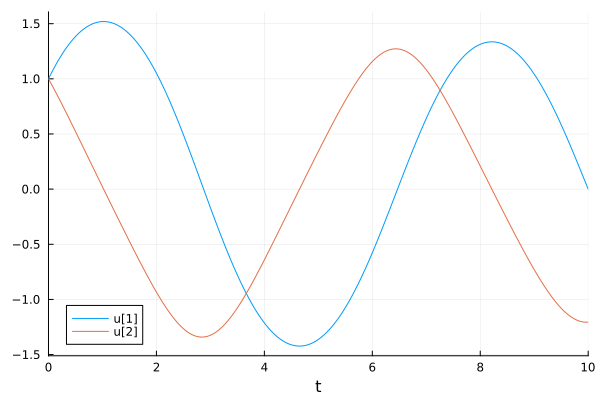

In [10]:
plot(pendulum_friction(τ))

------

**Problem 2** We can also differentiate with respect to the initial conditions.
Find an initial velocity such that the pendulum is at the bottom at $T = 10$ with
no friction, assuming $u(0) = 1$.

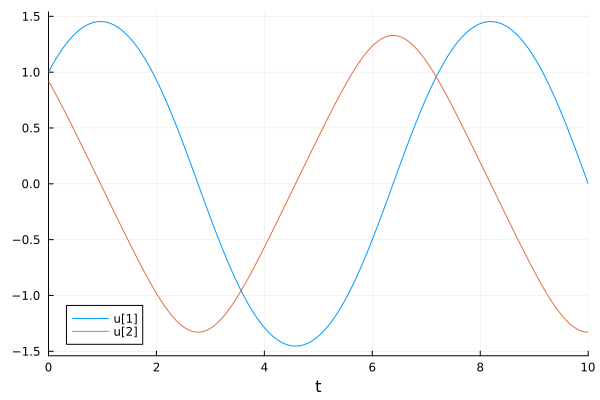

In [11]:
# TODO: Setup a function taking in the initial velocity and find the initial velocity so we end at rest.
# SOLUTION
function pendulum_initialvelocity(v₀)
    T = 10.0 # final time
    prob = ODEProblem(pendulum_rhs!, [1, v₀], (0.0, T), 0)
    solve(prob, Vern9(), abstol = 1e-10, reltol = 1e-10) # Vern9 is an explicit Runge-Kutta method
end

pendulum_initialvelocity_stop(v₀) = pendulum_initialvelocity(v₀)[end][1]

v0 = 1.0
for k = 1:10
    v0 = v0 - ForwardDiff.derivative(pendulum_initialvelocity_stop, v0) \ pendulum_initialvelocity_stop(v0)
end
v0, pendulum_initialvelocity_stop(v0)

plot(pendulum_initialvelocity(v0))
# END

**Problem 3** We can also compute gradients and Jacobians through solves using
forward-mode autmatic differentiation. For the predator and prey model, fix $α = γ = 1$
and initial conditions $x(0) = 1$, $y(0) = 2$.
Use automatic differentiation with vector Newton iteration  to choose
choose $β,δ$ so that $x(10) = y(10) = 1$.

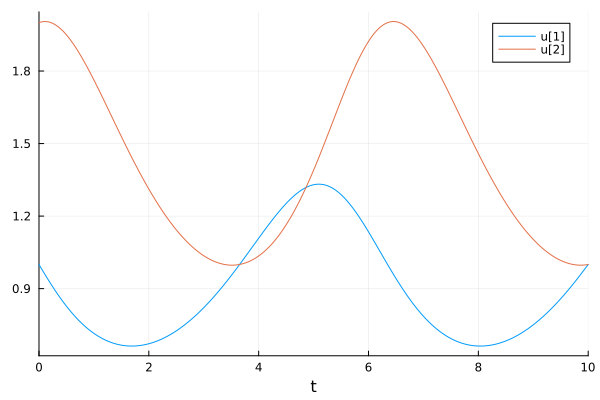

In [12]:
# TODO: find the parameters in predator and prey to reach the desired end condition
# SOLUTION
function predatorprey(βγ)
    β,γ = βγ
    T = 10.0 # final time
    prob = ODEProblem(predatorprey_rhs!, [1, 2], (0.0, T), (1,β,γ,1))
    solve(prob, Vern9(), abstol = 1e-10, reltol = 1e-10) # Vern9 is an explicit Runge-Kutta method
end

predatorprey_stop(βγ) = predatorprey(βγ)[end] .- 1

βγ = [1.0,1]

for _ = 1:10
    βγ = βγ - ForwardDiff.jacobian(predatorprey_stop, βγ) \ predatorprey_stop(βγ)
end

plot(predatorprey(βγ))
# END

------

## 4.3 Automatic-differentiation of ODEs with Zygote.jl

Zygote.jl also works with automatic differentation, but it requires another package: SciMLSensitivity.
Here is an example of computing the derivative. The catch is its more restrictive, in particular it requires that
the parameters are specified by a vector:

In [13]:
using Zygote, SciMLSensitivity

function pendulum_rhs_zygote!(du, 𝐮, τv, t)
    u,v = 𝐮
    τ = τv[1]
    du[1] = v
    du[2] = -sin(u) - τ*v
end

function pendulum_friction_zygote(τ)
    T = 10.0 # final time
    u₀, v₀ = 1.0,1 # initial conditions
    prob = ODEProblem(pendulum_rhs_zygote!, [u₀, v₀], (0.0, T), [τ])
    solve(prob, Vern9(), abstol = 1e-10, reltol = 1e-10) # Vern9 is an explicit Runge-Kutta method
end

pendulum_friction_zygote_stop(τ) = pendulum_friction_zygote(τ)[end][1] # find the value of u at the final time


@test pendulum_friction_zygote_stop'(0.1) ≈ ForwardDiff.derivative(pendulum_friction_stop, 0.1)

Test Passed

Now one might ask: how is Zygote.jl computing the derivative with reverse-mode automatic differentiation
when `pendulum_rhs_zygote!` is modifying the input, something we said is not allowed? The answer: its not.
Or more specifically: its computing the derivative (and indeed the pullback) using forward-mode automatic differentation.
But we can still use it for efficiently computing gradients and optimising.

Here is an example of the pendulum equation where we allow for a piecewise-constant frictions and optimise their values so the final solution
has roughly the same position and velocity as we started with. We first setup the problem and show we can
compute gradients:

In [14]:
function pendulum_rhs_zygote!(du, 𝐮, τs, t)
    u,v = 𝐮
    τ = τs[max(1,ceil(Int, 10t))]
    du[1] = v
    du[2] = -sin(u) - τ*v
end

function pendulum_friction_vec(τs)
    T = 10.0 # final time
    u₀, v₀ = 1.0,1 # initial conditions
    prob = ODEProblem(pendulum_rhs_zygote!, [u₀, v₀], (0.0, T), τs)
    solve(prob, Vern9(), abstol = 1e-10, reltol = 1e-10) # Vern9 is an explicit Runge-Kutta method
end

# We include an extra unused argument for parameters.
pendulum_friction_loss(τs, _) = norm(pendulum_friction_vec(τs)[end] .- 1) # find the value of u at the final time

# We can compute the gradient
@time gradient(pendulum_friction_loss, randn(100), ())

 16.463198 seconds (38.49 M allocations: 2.539 GiB, 3.81% gc time, 99.82% compilation time: <1% of which was recompilation)


([0.19526413586500538, 0.17320360909375518, 0.15096181792808822, 0.1296243135790579, 0.10989765760014611, 0.09159846877415778, 0.07464564957582351, 0.05893691345054442, 0.04423879373443246, 0.02935895380528997  …  -0.04083398799712152, -0.05515871061078249, -0.06853422483507002, -0.0815736532633295, -0.09412493572267515, -0.10501037755759814, -0.11398216087838513, -0.12153304649146142, -0.12722987315628448, -0.13024434495317333], nothing)

This can then be used an optimisation:

  4.578225 seconds (44.17 M allocations: 2.072 GiB, 3.46% gc time, 23.18% compilation time)


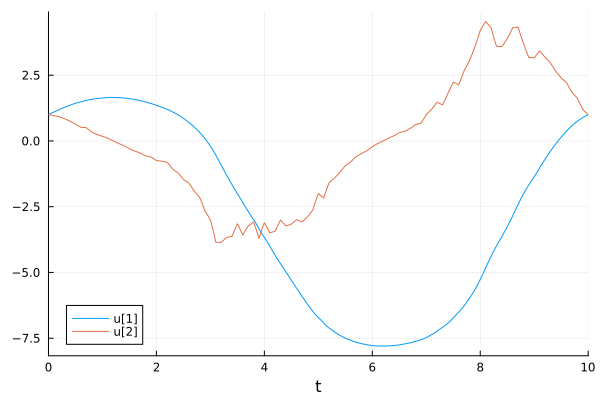

In [15]:
using Optimization, OptimizationOptimisers
prob = OptimizationProblem(OptimizationFunction(pendulum_friction_loss, Optimization.AutoZygote()), randn(100), ())
@time ret = solve(prob, Adam(0.03), maxiters=100)
plot(pendulum_friction_vec(ret.u))

**Problem 4** For the predator-prey model, Choose $α,β,γ,δ$ to try to minimize the 2-norm of $x(t) - 1$ evaluated at
the integer samples $t = 1,…,10$ using the initial condition $[x(0),y(0)] = [2,1]$. Hint: using `u = solve(...; saveat=1:10)` will cause `Vector(u)` to contain the solution
at the specified times. Different initial guesses will find different local minimum.

  3.456485 seconds (12.76 M allocations: 824.576 MiB, 3.52% gc time, 97.56% compilation time)


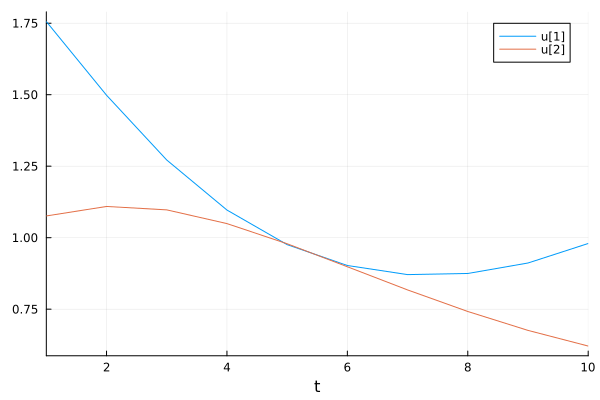

In [16]:
# SOLUTION


function predatorprey(ps)
    prob = ODEProblem(predatorprey_rhs!, [2.,1.], (0.0, 10.0), ps)
    solve(prob, Tsit5(), abstol = 1e-10, reltol = 1e-10, saveat=1:10)
end

function predatorprey_norm(ps, _)
    u = predatorprey(ps)
    norm(first.(Vector(u)) .- 1)
end

prob = OptimizationProblem(OptimizationFunction(predatorprey_norm, Optimization.AutoZygote()), [1.0,0.1,0.1,1], ())
@time ret = solve(prob, Adam(0.03), maxiters=300)
plot(predatorprey(ret.u))


## END

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*